In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical

### Generate State Space

The state space is 2-dimensional, consisting of `num_concepts` different classes. Class $c_i$ is generated by sampling from a normal distribution $~\mathcal{N}(\mu_{c_i}, \sigma_{c_i})$. The concept of a class is assumed to be its mean $\mu_{c_i}$.

In [2]:
num_concepts = 5
examples_per_concept = 100

(500, 2)


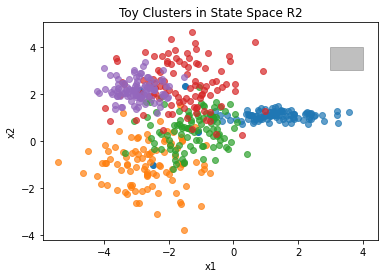

In [50]:
# Sample candidate class means from uniform distribution
x1 = np.random.uniform(-3, 3, num_concepts)
x2 = np.random.uniform(-3, 3, num_concepts)
means = np.stack((x1, x2), axis=1)

fig, ax = plt.subplots()
plt.scatter(x1, x2)

clusters = np.zeros((examples_per_concept*num_concepts, 2))
y = np.zeros(examples_per_concept*num_concepts)

for i in range(num_concepts):
    y[i*examples_per_concept: (i+1)*examples_per_concept] = i
    cov = [[np.random.uniform(0.01, 1), 0], [0, np.random.uniform(0.01, 1)]]
    x1, x2 = np.random.multivariate_normal(
        means[i], cov, size=examples_per_concept, check_valid='warn').T
    clusters[i*examples_per_concept: (i+1)*examples_per_concept] = np.stack((x1,x2), axis=1)
    plt.plot(x1, x2, 'o', alpha=0.7)

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax.add_patch(rect)
print(clusters.shape)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Toy Clusters in State Space R2")
plt.show()


In [3]:
def save_dataset_and_trajectories(filename, centroids, clusters, trajectories, rewards, unique_concepts, concepts, actions):
    np.savez(filename, centroids=centroids, clusters=clusters, trajectories=np.array(trajectories,
             dtype=object), rewards=np.array(rewards), unique_concepts=np.array(unique_concepts, dtype=object), concepts=np.array(concepts, dtype=object), actions=np.array(actions, dtype=object))


def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']
    


from sklearn.neighbors import KNeighborsClassifier
import numpy as np
means, clusters, _, _, _, _, _ = load_dataset_and_trajectories("saved_data/dataset_large.npz")

# Load some example data
X_train = np.array(clusters)
y_train = np.repeat(np.array([0,1,2,3,4]),100)
X_test = np.array([[1,1], [3,3],[0,-2]])

# Create a kNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=5) #smaller k values results in more fluctuation of the concepts

# Train the classifier
knn.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = knn.predict(X_test)

# Print the predicted labels
print(y_pred)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
[3 0 4]


### Environment Dynamics

Suppose the goal of the agent is to reach the upper right corner our confined state space, a square located at (3,3). Let the reward of of all steps in which the goal is not achieved by -1. Additionally, suppose there is a $\textit{wind}$ acting in the negative $x$ direction, pushing the agent further from its goal. Suppose also that the agent experiences the wind more severely in certain regions of the state space; characterised by the concept classes in the dataset.

Let the action space comprise of 4 discrete actions: {up, down, right, left}

The transtition to the next state $T(s'|s)$ is given as
$ s_{t+1} = s_{t} + \Delta_{ss} \cdot a_t + w(s_t) $,
Where $\Delta_{ss}$ is a step size, $a_t$ is a unit vector representing the action and $w(s_t)$ is a function which describes the $\textit{wind severity experienced by the agent}$ given the current state. Intuitively, we may want to avoid certain states in reaching our goal, or at least know if taking some action might lead to problematic states.

A possible definition of $w(s_t)$. The severity of the $\textit{wind}$ in each cluster may be normally distributed around the center of the cluster, i.e. focused at the center. Then the severity for a given position in the state space could be represented by the sum severities sampled from each distribution weighted by the distance to the cluster centroid.

### Generate Trajectories and Behaviour Policy

During trajectory generation, we can assign a state to a concept/cluster possibly by its K nearest neighbours, or simply to the class of its closest centroid. Then for each time step in a trajectory, we will have a tuple $(s_i, a_i, r_{i+1}, c_i)$.

* How to define a behaviour policy? Example: Starting in the bottom right corner, move up and right with greater and probability of moving left and down respectively.

In [8]:
means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_large.npz")
print(np.array(trajectories, dtype=object).shape)
print(np.array(rewards).shape)
print(np.array(unique_concepts, dtype=object).shape)
print(np.array(concepts, dtype=object).shape)
print(np.array(actions, dtype=object).shape)
print(means.shape)
print(clusters.shape)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(653,)
(653,)
(653,)
(653,)
(653,)
(5, 2)
(500, 2)


In [6]:
from gridworld.environment import WindyGridworld

num_concepts = 5
env = WindyGridworld(num_concepts=num_concepts, method="simple", knn=knn, means=means, policy_model=None, concept_model=None)

trajectories = []
rewards = []
unique_concepts = []
concepts = []
actions = []


# Create dataset in windy gridworld
for j in tqdm(range(500)):
    starting_positions = [np.array([-3,-3]),np.array([-4,2]),np.array([1,-3])]
    s = starting_positions[np.random.choice([0,1,2],1)[0]]
    env.play(True, trajectories, rewards, unique_concepts, concepts, actions, s=s)


## Save Dataset and Trajectory Information

In [8]:
filename = "saved_data/dataset_stochastic_knn"
save_dataset_and_trajectories(filename=filename, centroids=means, clusters=clusters, trajectories=trajectories,
                              rewards=rewards, unique_concepts=unique_concepts, concepts=concepts, actions=actions)

In [64]:
means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("dataset_knn.npz")
print(np.array(trajectories, dtype=object).shape)
print(np.array(rewards).shape)
print(np.array(unique_concepts, dtype=object).shape)
print(np.array(concepts, dtype=object).shape)
print(np.array(actions, dtype=object).shape)
print(means.shape)
print(clusters.shape)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(627,)
(627,)
(627,)
(627,)
(627,)
(5, 2)
(500, 2)


409


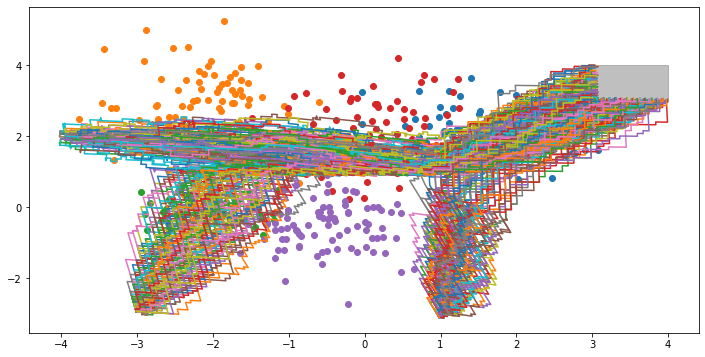

In [7]:
#Visualise all trajectories
print(len(trajectories))
fig, ax2 = plt.subplots(figsize=(12,6))
N = 0
for history in trajectories:
    N += len(history)
    plt.plot(history[:, 0], history[:, 1], label="Trajectory")
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*examples_per_concept
    end = (i+1)*examples_per_concept
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

# plt.legend()
plt.show()


Reward: -223


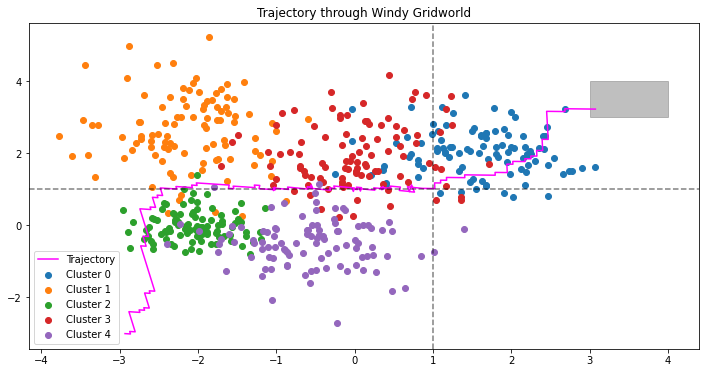

409


In [67]:
fig, ax2 = plt.subplots(figsize=(12,6))
index = np.random.randint(0,len(trajectories))
history = np.array(trajectories[index])
# print(f"Concepts visited: {concepts[index]}")
print(f"Reward: {rewards[index]}")
plt.plot(history[:, 0], history[:, 1], color="magenta", label="Trajectory")
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*examples_per_concept
    end = (i+1)*examples_per_concept
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()

print(len(trajectories))

In [68]:
unique_concept_combinations_visited = []

for comb in unique_concepts:
    if comb not in unique_concept_combinations_visited:
        unique_concept_combinations_visited.append(comb)
print(f"Number of unique concept combinations visited {len(unique_concept_combinations_visited)}")
mean_reward_per_combination = np.zeros(len(unique_concept_combinations_visited))
combination_occurence = np.zeros(len(unique_concept_combinations_visited))

for i,r in enumerate(rewards):
    comb = unique_concepts[i]
    unique_comb_index = unique_concept_combinations_visited.index(comb)
    mean_reward_per_combination[unique_comb_index] += r
    combination_occurence[unique_comb_index] += 1


mean_reward_per_combination = mean_reward_per_combination/combination_occurence
for i,c in enumerate(unique_concept_combinations_visited):
    print(f"Concepts {c} have mean reward {mean_reward_per_combination[i]}")

#~50k trajectories
# Store s,a,s',r,c for every time step for each trajectory
# learn behaviour policy to get pi_b (NN to learn this. Output action, input states-summary|concepts. over states and actions (usual) or over states and concepts
# then find ratios of pi_e/pi_b 

Number of unique concept combinations visited 7
Concepts [0, 2, 3] have mean reward -221.0909090909091
Concepts [0, 4] have mean reward -145.3272727272727
Concepts [0, 1, 3] have mean reward -165.27868852459017
Concepts [0, 2, 3, 4] have mean reward -222.65853658536585
Concepts [0, 3, 4] have mean reward -148.0
Concepts [0, 1, 2, 3] have mean reward -201.59375
Concepts [0, 1, 2, 3, 4] have mean reward -211.66666666666666
